# Infer ***golgi*** - part 6️⃣

--------------
## OVERVIEW
In notesbooks 4-9, we will go how each organelle is segmented. These segmentation workflows are completely independent of each other and can be run in any order. Additionally, the entire image will be processed in this notebook, irrespective of the single cells identified in notebooks 1-3. The cell mask will be applied to the organelle segmentation outputs before quantification (as outlined in [10_regionprops](./10_regionprops.ipynb)). 

This notebook goes through the workflow steps to segment the ***golgi*** -- one of the six organelles of interest.

## OBJECTIVE: ✅ Infer sub-cellular component  ***golgi***  
Segment the ***golgi*** from a single channel (membrane marker). This workflow was optimized for images of fluorescently tagged sialyltransferase1 (SiT1), a membrane protein. The Golgi has both the classical cisternae structure as well as small golgi derived vesciles, so we are utilizing two segmentation methods to idenfity the entire Golgi structure.


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper, dot_3d_wrapper
from aicssegmentation.core.utils import topology_preserving_thinning
from skimage.measure import label

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc.core.img import *
from infer_subc.organelles import fixed_infer_cellmask_fromcomposite, fixed_infer_nuclei_fromlabel
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )  

%load_ext autoreload
%autoreload 2


## Get and load Image for processing

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) /  "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


---------------------

## infer ***golgi complex***

## summary of steps 

➡️ INPUT
- select single channel containing the lysosome marker (channel number = user input)

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)

CORE PROCESSING
- apply MO thresholding method with topology preserved thinning function from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options; thinning amount = user input)
- apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)
- combine the two segmentations with logical *OR*

POST-PROCESSING
- fill holes (hole size = user input)
- remove small objects (object size = user input)

OUTPUT  ➡️
- label unique golgi objects based on connectivity
- save labeled ***golgi*** (golgi, GL) as unsigned integer 16-bit tif files


> Generally following the Allen Cell Segmenter procedure for segmentation of Golgi from the [sialyltransferase 1 (ST6GAL1)](https://www.allencell.org/cell-observations/category/golgi-apparatus) marker. Sourced from: this [script](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_st6gal1.py).

## EXTRACT prototype

In [4]:
###################
# INPUT
###################
raw_golgi = select_channel_from_raw(img_data, GOLGI_CH)

## PRE-PROCESSING prototype


In [5]:
###################
# PRE_PROCESSING
###################
median_sz = 4
gauss_sig = 1.34

struct_img =  scale_and_smooth(raw_golgi,
                               median_size = median_sz, 
                               gauss_sigma = gauss_sig)

## CORE PROCESSING prototype

In [6]:
###################
# CORE_PROCESSING
###################
################################
# segment the majority of the golgi with this global and local thresholding method
thresh_method = 'tri'
cell_wise_min_area = 1200
thresh_adj = 1

bw = masked_object_thresh(struct_img, 
                          global_method=thresh_method, 
                          cutoff_size=cell_wise_min_area, 
                          local_adjust=thresh_adj)

# thin segmentation with maintain a minimal required thickness
thin_dist = 1
thin_dist_preserve = 1.6

bw_thin = topology_preserving_thinning(bw, thin_dist_preserve, thin_dist)

# segment small round structures with this (golgi vesicles)
dot_method = "3D"

bw_extra = dot_filter_3(struct_img, 1.6, 0.02, 0, 0, 0, 0, dot_method)

# combine the two segmentations together
bw_combine = np.logical_or(bw_extra, bw_thin)

## POST-PROCESSING prototype

In [7]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 1

small_object_width = 3

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_combine, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

## LABELING prototype

In [8]:
###################
# LABELING
###################
golgi_labels = label_uint16(cleaned_img2)

In [9]:
golgi_labels.dtype

dtype('uint16')

## Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()

31-May-23 12:36:02 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x686+1628+1047 (frame: 1108x733+1619+1009) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1365x859+1629+1054 (frame: 1383x906+1620+1016) margins: 9, 38, 9, 9 minimum size: 612x589 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=630,636 maxtrack=0,0)


In [11]:
viewer.add_image(
    struct_img)

viewer.add_image(
    cleaned_img2,
    opacity=0.3,)

viewer.add_labels(
    golgi_labels,
    opacity=0.3)

<Labels layer 'golgi_labels' at 0x2cf66283f40>

## SAVE inferred golgi to .tif file

In [12]:
out_file_n = export_inferred_organelle(golgi_labels, "golgi", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_14_Unmixing-golgi


----------
## DEFINE `_infer_golgi` function

Based on the _prototyping_ above define the function to infer the golgi.  

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [13]:
##########################
#  infer_golgi
##########################
def _infer_golgi(
            in_img: np.ndarray,
            golgi_ch: int,
            median_sz: int,
            gauss_sig: float,
            mo_method: str,
            mo_adjust: float,
            mo_cutoff_size: int,
            min_thickness: int,
            thin_dist: int,
            dot_scale_1: float,
            dot_cut_1: float,
            dot_scale_2: float,
            dot_cut_2: float,
            dot_scale_3: float,
            dot_cut_3: float,
            dot_method: str,
            min_hole_w: int,
            max_hole_w: int,
            small_obj_w: int,
            fill_filter_method: str
        ) -> np.ndarray:

    """
    Procedure to infer golgi from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    min_thinkness: 
        Half of the minimum width you want to keep from being thinned.
        For example, when the object width is smaller than 4, you don't
        want to make this part even thinner (may break the thin object
        and alter the topology), you can set this value as 2.
    thin_dist: 
        the amount to thin (has to be an positive integer). The number of
         pixels to be removed from outter boundary towards center.
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    
    Returns
    -------------
    golgi_object
        mask defined extent of golgi object
    """

    ###################
    # EXTRACT
    ###################    
    golgi = select_channel_from_raw(in_img, golgi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    golgi =  scale_and_smooth(golgi,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)
    ###################
    # CORE_PROCESSING
    ###################
    bw = masked_object_thresh(golgi, global_method=mo_method, cutoff_size=mo_cutoff_size, local_adjust=mo_adjust)

    bw_thin = topology_preserving_thinning(bw, min_thickness, thin_dist)

    bw_extra = dot_filter_3(golgi, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    bw = np.logical_or(bw_extra, bw_thin)
    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1


## DEFINE `_fixed_infer_golgi` function


In [14]:
##########################
#  fixed_infer_golgi
##########################
def _fixed_infer_golgi(in_img: np.ndarray ) -> np.ndarray:
    """
    Procedure to infer golgi from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    Returns
    -------------
   golgi_object
        mask defined extent of golgi object
    """

    golgi_ch = 3
    median_sz = 4
    gauss_sig = 1.34
    mo_method = 'tri'
    mo_adjust = 1
    mo_cutoff_size = 1200 
    min_thickness = 1.6
    thin_dist = 1
    dot_scale_1 = 1.6
    dot_cut_1 = 0.02
    dot_scale_2 = 0
    dot_cut_2 = 0
    dot_scale_3 = 0
    dot_cut_3 = 0
    dot_method = '3D'
    min_hole_w = 0
    max_hole_w = 0
    small_obj_w = 3
    fill_filter_method = "3D"

    return _infer_golgi(
        in_img,
        golgi_ch,
        median_sz,
        gauss_sig,
        mo_method,
        mo_adjust,
        mo_cutoff_size,
        min_thickness,
        thin_dist,
        dot_scale_1,
        dot_cut_1,
        dot_scale_2,
        dot_cut_2,
        dot_scale_3,
        dot_cut_3,
        dot_method,
        min_hole_w,
        max_hole_w,
        small_obj_w,
        fill_filter_method)

# TEST  `infer_golgi` function defined above

In [15]:
_golgi_object =  _fixed_infer_golgi(img_data) 

_golgi_object.dtype

dtype('uint16')

In [16]:
np.all(golgi_labels == _golgi_object)

True

------------------

# TEST `infer_golgi` exported functions

The prototype _infer_golgi was copied to the [.organelles.golgi](../infer_subc/organelles/golgi.py) sub-module.

In [17]:
from infer_subc.organelles import infer_golgi, fixed_infer_golgi

golgi_object =  fixed_infer_golgi(img_data) 

In [18]:
np.all(_golgi_object == golgi_object)

True

## Visualize  2


In [19]:
viewer.add_image(
    _golgi_object,
    opacity=0.3)

viewer.add_labels(
    golgi_object,
    opacity=0.3)

<Labels layer 'golgi_object' at 0x2cf7d09b4f0>

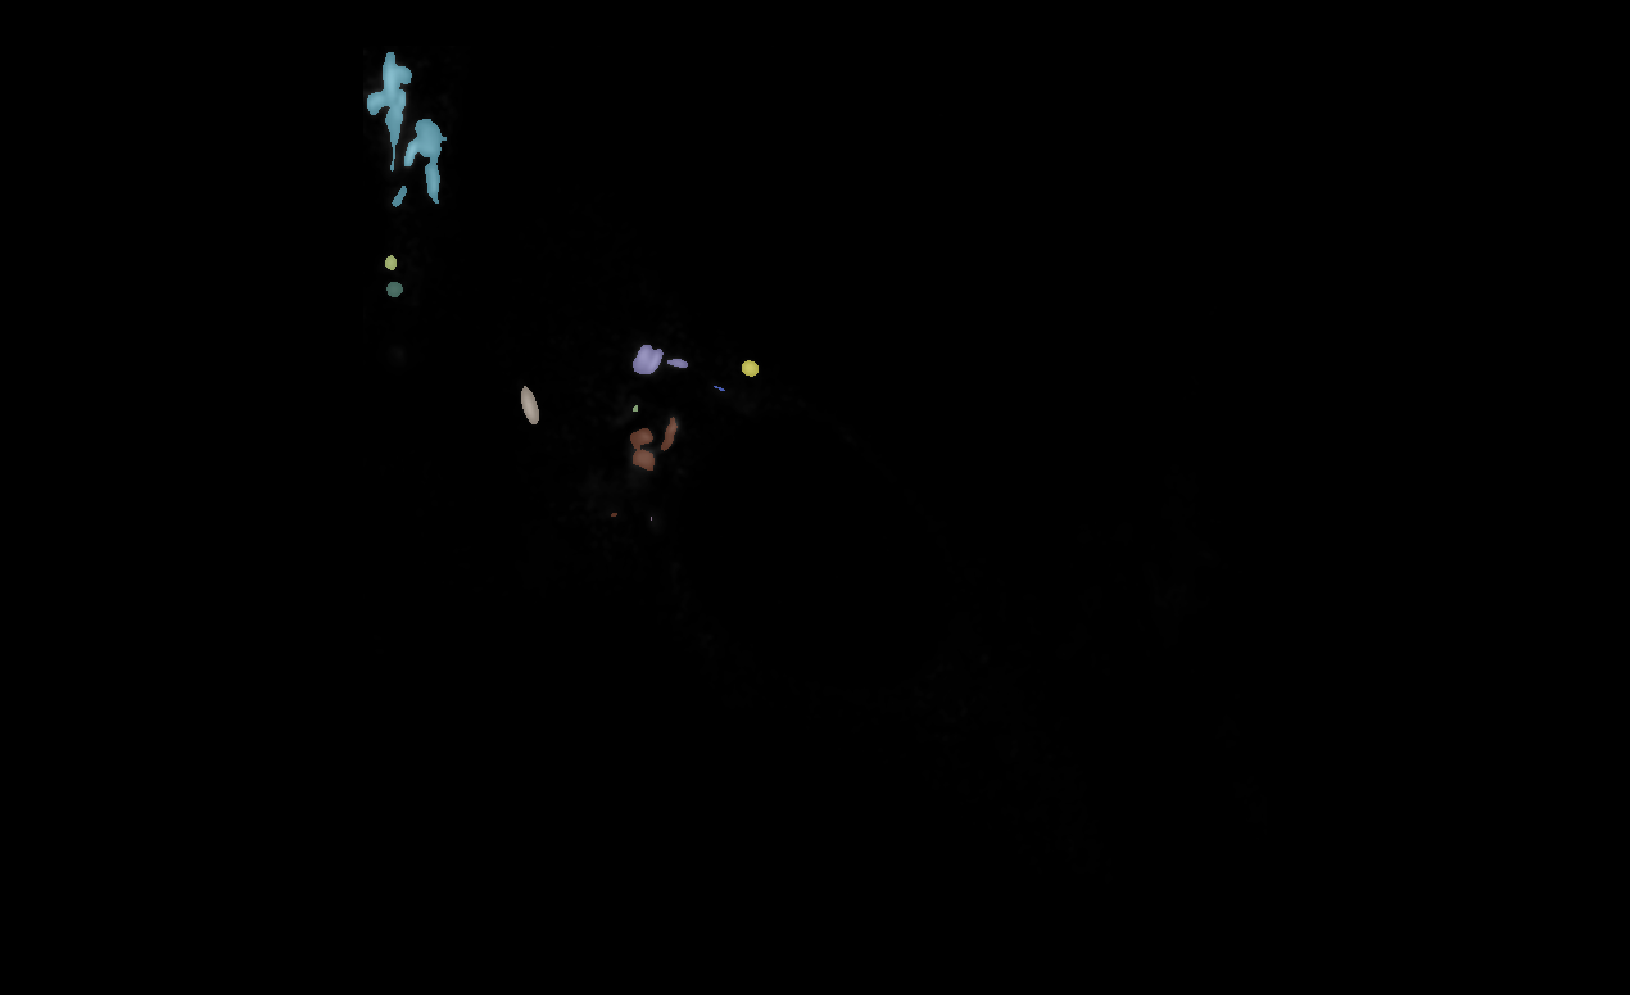

In [20]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-------------
## SUMMARY

The above details how the golgi body object is inferred.  

### NEXT: INFER PEROXISOME

proceed to [07_infer_perox.ipynb](./07_infer_perox.ipynb)
